# Exploring unique values in iDigBio using Apache Spark



[Matthew Collins](mcollins@acis.ufl.edu) and [Alex Thompson](godfoder@acis.ufl.edu)

In [1]:
###################################################################
# WARNING WARNING WARNING WARNING WARNING WARNING WARNING WARNING #
###################################################################

# If you are planning on running this notebook as is with the data
# as used in this post, you will need 64 GB of memory and about 15
# minutes on a good processor. I've made no attempt to make this
# small or fast.

In [2]:
%matplotlib inline 
from ggplot import *
import pandas as pd
from os import listdir

def get_counts(fn):
    return pd.read_csv(fn, header=None, names=["value", "count"])


def load_output_dir(dn, fields=None):
    retval = {}
    if fields is None:
        fields = []
        files = listdir(dn)
        for l in files:
            fields.append(l[len("unique_"):-1 * len(".csv")])

    for d in fields:
        
        l = "{0}/unique_{1}.csv".format(dn, d)
        #print "Loading {0}, fields is {1}".format(l, fields)
        retval[d] = get_counts(l)
        
    return retval


def plot_bar(df, y, title, xlabel, ylabel, log=False):
    p = ggplot(aes(x="x", y=y), data=df) \
        + geom_bar(stat='identity') \
        + theme(axis_text_x = element_text(angle = 90, hjust = 0.5)) \
        + scale_x_discrete(limits=(0 - 0.5, df.shape[0] + 0.5), 
                           breaks=range(0, df.shape[0]), 
                           labels=df.index) \
        + ggtitle(title) \
        + xlab(xlabel) \
        + ylab(ylabel)
        
    if log:
        p = p + scale_y_log10()
        
    return p


def plot_hist(df, x, title, xlabel, ylabel):
    # Figure size: https://github.com/yhat/ggplot/issues/95
    p = ggplot(aes(x=x), data=df) \
    + geom_histogram() \
    + scale_x_continuous(limits=(0-0.01, max(df[x].max()+0.01, .11))) \
    + ggtitle(title) \
    + xlab(xlabel) \
    + ylab(ylabel) \
    + theme_matplotlib(rc={"figure.figsize": "11, 4", "figure.max_open_warning": False}, 
                       matplotlib_defaults=False)
    return p


def plot_line(df, df_raw, x, y, title, xlabel, ylabel, log=False):
    p = ggplot(aes(x=x, y=y), data=df) \
        + geom_line(size=1, color="green") \
        + geom_line(aes(x=x, y=y), data=df_raw, size=1) \
        + ggtitle(title) \
        + xlab(xlabel) \
        + ylab(ylabel)
    if log:
        p = p + scale_y_log10()
        
    return p


Data exploration for large datasets is always challenging. Often you are left with deciding between subsetting the dataset (randomly or on some facet), making slow progress waiting for results just to find that something needs to be fixed, or optimizing code for performance when you don't even know if the result is going to be interesting. Having a high-performance system capable of ad-hoc investigation has always been difficult and/or expensive.

iDigBio currently has over 45 million records with more than 200 data fields. Most are described by the [Darwin Core](http://rs.tdwg.org/dwc/) and [Audubon Core](http://terms.tdwg.org/wiki/Audubon_Core) standards, some are unique to a particular provider's data use, and a handful are used internally by iDigBio. One question that comes up often is "What are the unique values in a field?"

As it turns out, that is a computationally expensive question to answer for a data set with 45 million records. Considering the [dwc:country](http://rs.tdwg.org/dwc/terms/#country) field, your first thought might be to write a SQL query like:

    SELECT country, count(*) 
    FROM all_idigbio GROUP BY country;

iDigBio's data flexibility and per-record performance comes from storing provided data as PostgreSQL JSON data types. In such a schema, there is no county column to be indexed and grouped by. In our testing, an analogous query on the JSON column takes far to long to be practical. For a searchable store, we use Elastic Search which unfortunately is also not optimal for this type of query. Elastic Search's indexes are tuned for returning the most common occurrences and not exhaustive lists. (See our [top API endpoints](https://github.com/iDigBio/idigbio-search-api/wiki#top-n-records) for an example.)

Another option might be to get a CSV copy of iDigBio (which is around 32 GB) and write some code in Python or another language to iterate through lines and keep track of unique values. In our experience it is quite expensive to keep track of so many unique values, and adding multi-threading and multi-processing into the mix to manage the computational cost adds a great deal of operational complexity. 

So what to do?

## Apache Spark

If you have looked in to the big data analytics ecosystem in the past few years, you might have come across [Apache Hadoop](https://hadoop.apache.org/). Traditionally Hadoop has been hard: hard to install, hard to maintain, and hard to write code for. But the computation pattern that Hadoop implements, referred to as [map-reduce](https://en.wikipedia.org/wiki/MapReduce), is a great pattern for doing computations over very large datasets. Hadoop was often the best solution for working with large datasets.

In the last two years a new computation framework has been open sourced and is [growing in popularity](https://www.google.com/trends/explore#q=apache%20spark): [Apache Spark](http://spark.apache.org/). Spark is much easier to use than Hadoop and in most cases performs faster. It can perform map and reduce operations similar to Hadoop (though the implementation is very different) which allows for a convenient and flexible way to express complex operations.

Three easy parts about how Spark works are:

1. It is happy to use text files for input
1. You don't need to write special code to make your analysis happen in parallel
1. The same code can be run on one local machine or a whole cluster of machines

This means we can get close to the convenience of the Python and CSV option above and also run it in parallel on either a local development machine or a whole compute cluster. All we need is a running install of Spark and a few lines of Python. (Spark also has libraries for Scala and R if you prefer those languages.)

During the iDigBio [API Hackathon](https://github.com/idigbio-api-hackathon/HackathonCentral/wiki), [Jorrit Poelen](https://github.com/jhpoelen) from [Global Biotic Interactions](http://www.globalbioticinteractions.org/about.html) put together [some test code](https://github.com/idigbio-api-hackathon/idigbio-spark) to join iDigBio records to [Global Names Index](http://gni.globalnames.org/) names. Based on this trial, we decided to invest more into Spark.

To try Spark out on a larger scale, we built a 6-node, 96 thread Spark cluster. This is a test setup based on [Cloudera's](http://www.cloudera.com/content/cloudera/en/home.html) bundle of Spark and other Apache tools. We then wrote a Python script to read in both the raw and as-served occurrence CSV files that are in the [Darwin Core Archive](http://rs.tdwg.org/dwc/terms/guides/text/index.htm) of all iDigBio data that can be downloaded from our [full record set exports site](http://s.idigbio.org/idigbio-static-downloads?max-keys=10000). For each field, the script produces a CSV file with all of the unique values in that field and the number of records that had that value.

An abbreviated excerpt from the Python script showing the core Spark operations is below.


```python
fn = "data/{0}/occurrence{1}.csv"
     .format(recordset, raw)
sc = SparkContext(appName="UniqueCSVline")

# Create a Resilient Distributed Dataset (RDD) 
# containing a python dictionary of values for
# each record from the CSV of all iDigBio data
# and cache the RDD to memory
records = sc.textFile(fn)
parsed = records.map(lambda x: 
                     parse(x.encode("utf8"), 
                     headers) )
parsed.cache()

# For each field we want the unique values of,
# apply the map-reduce strategy to find all the
# unique values
for field in fields:
    counts = parsed.map(lambda x: (x[field], 1))
    totals = counts.reduceByKey(add)

    # Collect all the results on one node and 
    # write them to a CSV file
    iter = totals._jrdd.toLocalIterator()
    output = totals.
             _collect_iterator_through_file(iter)
    with open(out_fn, "wb") as f:
        csvwriter = unicodecsv.writer(f, "excel")
        for (word, count) in output:
            csvwriter.writerow([word, count])
```

This still takes a while to run since it loops over each field. To do the 32 GB data set containing all data as indexed in [Elastic Search](https://www.elastic.co/products/elasticsearch) and served in the portal, it loops about 75 times in a little over 2 hours with translates to about 750,000 records per second. For the raw data as originally provided to us, there are over 200 fields and that takes closer to 8 hours. Much of that time, perhaps as much as 25%, is the inefficient but convenient way we chose to write the results to CSV. Our code is nowhere near optimal and this is just a test cluster. Spark scales really well and we have about 275 servers here at the Advanced Computing and Information Systems Lab ([ACIS](https://www.acis.ufl.edu/)) [machine room](https://www.acis.ufl.edu/research/facilities).

## Preliminary characterization

We made Python [Pandas](http://pandas.pydata.org/) data frames by importing those text files into this [iPython notebook](http://ipython.org/notebook.html). For some initial analysis we wanted to look at how many unique values there were, the cardinality, of each of the fields in the indexed data. Not all the fields were interesting. Many were provided by only one collection, some fields are designed to be unique, etc. So we trimmed off fields where more than 95% of the records had unique values and fields that had fewer than 100 unique values.

The result is a bar graph of how many unique values are present in iDigBio for about 55 of the indexed fields: (You can view this full-size by right-clicking on the image and choosing "View Image".)

In [4]:
# Load all the unique values of all the processed fields
# Note for all idigbio, this takes at least 5 minutes and 30 GB of memory
limited_fields = None
data_dir = "unique_idigbio_all_2015_08_25"
counts = load_output_dir("../{0}".format(data_dir), limited_fields)


In [5]:
# Build dataframe containing the number of unique values for every field
c = {}
for k, df in counts.iteritems():
    c[k] = df.shape[0]

cardinalities = pd.DataFrame(c.values(), index=c.keys(), columns=["card"])

# Reduce the dataframe to just those fields that are not completely unique or contain
# mostly the same values.
max_card = cardinalities.max()["card"] * 0.95
#min_card = 100000
min_card = 100
cardinalities = cardinalities[cardinalities["card"] < max_card]
cardinalities = cardinalities[cardinalities["card"] > min_card]

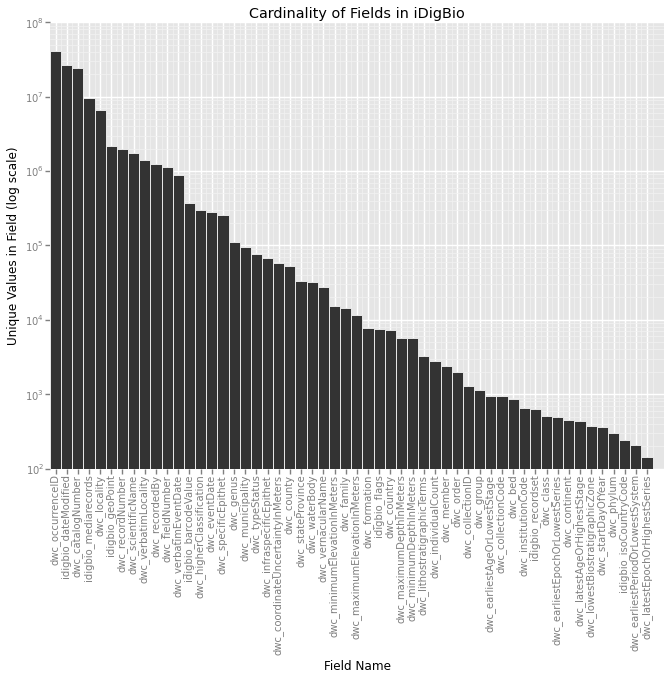

<ggplot: (8790686917057)>


In [6]:
# Sort for plotting and add an integer for the x-axis
cardinalities.sort(columns="card", inplace=True, ascending=False)
cardinalities["x"] = range(0, cardinalities.shape[0])

p = plot_bar(cardinalities, "card",
             "Cardinality of Fields in iDigBio",
             "Field Name",
             "Unique Values in Field (log scale)",
             log=True)
print p

The most interesting thing to notice is that [dwc:occurenceID](http://rs.tdwg.org/dwc/terms/#occurrenceID) and [dwc:catalogNumber](http://rs.tdwg.org/dwc/terms/#catalogNumber) were not more than 95% unique. The dwc:occurrenceID bar is a touch over 40 million (note the log scale) and there are 45 million records in this data dump. We're planning a deeper look at things that are used as identifiers in the future.

Some other highly unique fields were [dwc:scientificName](http://rs.tdwg.org/dwc/terms/#scientificName) and [dwc:recordedBy](http://rs.tdwg.org/dwc/terms/#recordedBy). There is a lot of room for exploration in these fields. With maybe [1.2 million species being classified](http://www.nature.com/news/2011/110823/full/news.2011.498.html), does iDigBio have a representative sample of all known species or is our scientific name field really messy? Did 1.1 million different people collect museum specimens in the last 200 years?

## Comparing raw and cleaned data using frequency

In addition to the cardinality, we can also look at the frequency with which each value occurs within a field. And to look a little at our cleaning efficiency, we can look at the frequency distributions of values both before and after data goes through iDigBio's data cleaning efforts.

(An aside about iDigBio's cleaning: From the raw data, we try to standardize values before we put data in our searchable index. The reason is that when people are searching, it is best to guide them to using a canonical value like "united states" instead of having everyone construct something like "us or usa or united s. or...". We colloquially call this "cleaned" but really it is our best guess as to the intention of the provider. We do not change the raw data provided to us. We [flag](https://github.com/iDigBio/idigbio-search-api/wiki/Data-Quality-Flags) these changes in our portal and data api so you can see what we've done: http://portal.idigbio.org/portal/records/dd01dd35-ff49-4a7f-b445-851a918096b9)

Below are graphs showing the cumulation of records over each unique value for a given field. The green lines show the cleaned values for the field and the black line shows the raw data provided to us. The unique values along the x-axis are sorted from least common to most common to convey how rapidly the frequency of values changes.

Note that the actual values are not shown on the x-axis, there isn't room. The numbers on the x-axis are an increasing integer but you can tell how many unique values there are in a field from it. Also note that blank values in fields are not considered on the y-axis.

Here's the graph of dwc:country:

In [10]:
# Subset of fields for developing graphs, don't need to load all
limited_fields = ["dwc_country", "dwc_order", "dwc_catalogNumber", "dwc_locality"]
data_dir = "unique_idigbio_all_raw_2015_08_25"
counts_raw = load_output_dir("../{0}".format(data_dir), limited_fields)

In [11]:
# As an alternative to the above, lets try a cumulative records graph. This shows the 
# cumulative number of records as each value is considered from most uncommon value to most 
# common.
def cumulate_df(df):
    # Remove blank/null value line, sort by increasing count
    df = df.sort("count")[ df["value"].notnull() ]
    
    # If the result is nothing left, return False
    if not df.shape[0] > 0:
        return False
    
    # Calculate cumulative count and percentage of records
    df["cum_count"] = df["count"].cumsum()
    df["cum_perc_pop"] = df["cum_count"] / df["count"].sum() * 100
    
    # add increasing integer x representing number of values for plotting
    df["x"] = range(0, df.shape[0])
    df["x_perc"] = df["x"] / df.shape[0] * 100
    
    return df

# Cumulate all the raw and corrected dataframes into dfs for graphing
dfs = {}
dfs_raw = {}
for f in limited_fields:
    df = cumulate_df(counts[f])
    if df is not False:
        dfs[f] = df
        
for f in limited_fields:
    df = cumulate_df(counts_raw[f])
    if df is not False:
        dfs_raw[f] = df


figs = {}
for f in dfs.keys():
    
    if not isinstance(dfs_raw.get(f), pd.DataFrame):
        #print "No raw data for {0}".format(f)
        continue

    #print "Plotting {0}".format(f)
    figs[f] = plot_line(dfs[f], dfs_raw[f], "x", "cum_count",
                         "Cumulation of record counts by value for {}".format(f),
                         "Values, ascending frequency",
                         "Cumulative number of records")
    
#figs

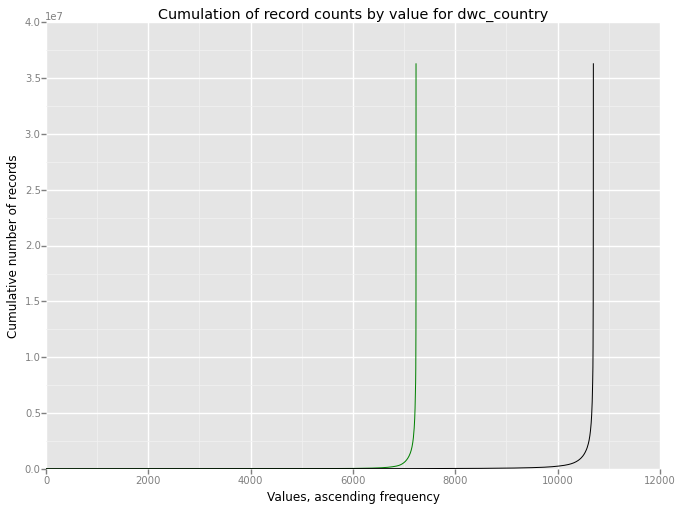

<ggplot: (8790686704273)>

In [12]:
figs["dwc_country"]

This is a typical curve for many of the fields in iDigBio. There is a long flat part representing many values that occur in only a few records followed by an upward curve for a few values that are common. Then finally the line spikes upward rapidly showing that a few values are in most of the data. You can see a slight knee where the line becomes vertical at the most frequent value: "united states".

From looking at the scales of this graph you can see that there are a lot of values in this field that you wouldn't expect. There are only about 195 countries in the world but in the raw data there are nearly 11,000 different values. When the field is cleaned up, the number of unique values drops significantly as multiple representations of the same data get merged.

Even after cleaning there are more then 7,000 unique values in the field. The [second most common value](http://search.idigbio.org/v2/summary/top/records?top_fields=[%22country%22]), "brasil", is the Portuguese spelling of Brazil. Which is "correct"? There are lots of heavy misspellings that are hard to automatically correct and there are values that don't fit the definition of the field like "off shore norway" and "afrique centrale".

This is a good graph to keep in mind when you are trying to "just find the records in country X".

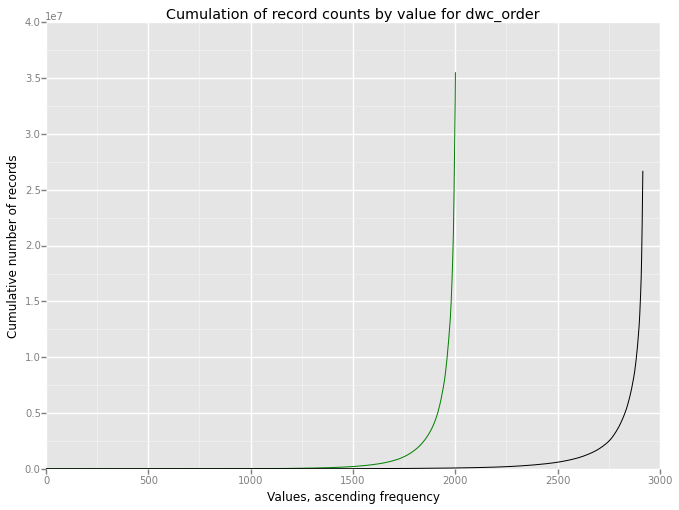

<ggplot: (8792651291805)>

In [13]:
figs["dwc_order"]

With the [dwc:order](http://rs.tdwg.org/dwc/terms/#order) field, things are a little different. Much of the data in iDigBio does not have higher taxonomy filled in so the raw data has fewer unique orders. Our standardization actually adds data to records from lookups in [GBIF's backbone taxonomy](http://www.gbif.org/dataset/d7dddbf4-2cf0-4f39-9b2a-bb099caae36c). You can see the corrected curve ends at a higher cumulative number of records. However, even though we're adding data, the cleaned curve shows fewer unique values because we're adding in valid orders that likely already exist in the dataset and getting rid of non-standard orders. When running some test records sets through this notebook, we found some individual record sets where the corrected curve was to right of the raw curve indicating that we were adding more orders than that specific provider was sending us.

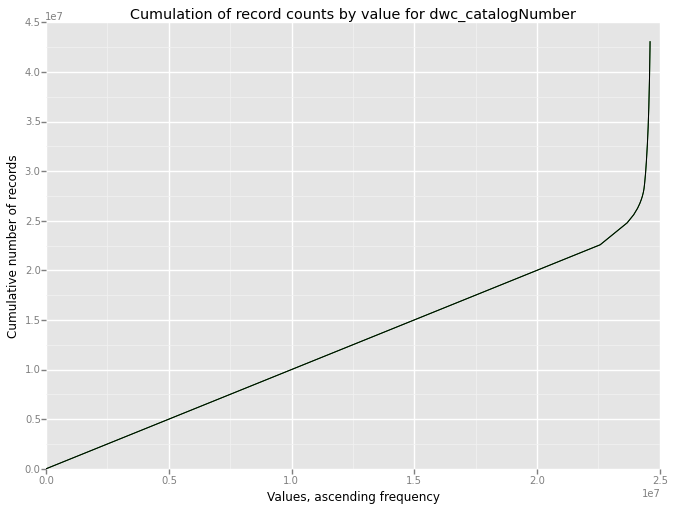

<ggplot: (8790686828769)>

In [14]:
figs["dwc_catalogNumber"]

Here is the dwc:catalogNumber field. If catalog number was globally unique this would be a line with a slope of 1. Of course, they aren't but the lower section of the line does show that there are a lot of unique catalog numbers out there. Then you can see some knees and segments with slope 2, 3, etc. The big spike at the end is really interesting and we'll be looking at that soon. What few hundred thousand values of dwc:catalogNumber are responsible for nearly 20 million records? Can you answer this question using the [iDigBio API](http://search.idigbio.org/v2/summary/top/records/?top_fields=[%22catalognumber%22]&count=1000)?

We don't clean this field so there's no change between raw and indexed.

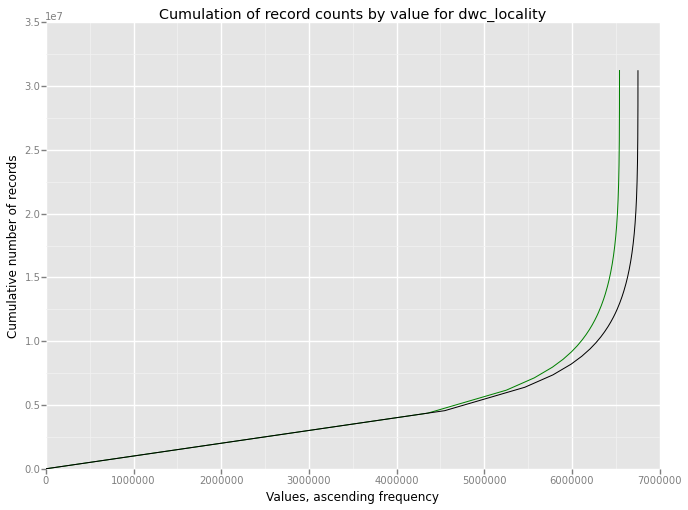

<ggplot: (8790686652325)>

In [15]:
figs["dwc_locality"]

Locality shows some similar trends with the lower part of the curve being several line segments clearly showing values that appear exactly once, twice, and three times.

What is interesting about this graph is that we don't clean locality strings. All we do is lowercase them in the index. The cleaned line shows fewer unique values simply because of the number of locality strings that differ by case only.

## Next steps

We are working on exposing our Spark cluster publicly so you don't have to transfer 30+ GB text files and manage Java memory settings to run iDigBio though your own Spark code. If that is something that interests you, send an email to idigbio@idigbio.org or join our [API mailing list](http://lists.ufl.edu/cgi-bin/wa?A0=IDIGBIO-API-USERS-L) where we announce programming interfaces.

Spark isn't difficult to get started with yourself if you prefer. Installation of a stand-alone setup requires [Java](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html) and any of the [pre-build downloads](http://spark.apache.org/downloads.html) extracted somewhere. (You don't need to worry about Hadoop version if you're developing locally.) The [official quickstart](http://spark.apache.org/docs/latest/quick-start.html) has examples in Scala and Python.

### Footnote

This blog post was written from an iPython Notebook. You can [view the notebook through Github](https://github.com/iDigBio/idb-spark/blob/master/notebook/Cardinality_of_iDigBio_Data.ipynb), clone or fork the [github repository](https://github.com/iDigBio/idb-spark/) containing the notebook and Spark code, or look at the code in-line by clicking the button below.

If you want to play with this notebook without figuring out Spark, you can get a .zip file containing all the [cleaned unique values in each field](http://s.idigbio.org/idigbio-static-downloads/unique_idigbio_all_2015_08_25.zip) (5 GB) or the [raw unique values](http://s.idigbio.org/idigbio-static-downloads/unique_idigbio_all_raw_2015_08_25.zip) (3 GB) in iDigBio. Just extract it in the directory after you clone the Github repository. The [full iDigBio dump](http://s.idigbio.org/idigbio-static-downloads/idigbio_all_2015_08_25.zip) (20 GB) used to generate these values is also availible.

In [16]:
# Hiding/Showing input cells
# http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')